In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-6dj641cr/pyyaml_9922b7cc534a480f9ceb34f21e032891/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/dist.py

In [2]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

detectron2 version: 0.6


In [3]:
import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

In [5]:
import json
import random
from pathlib import Path
from detectron2.data.datasets import register_coco_instances
# Set random seed for reproducibility
random.seed(42)

# Load the original COCO annotation file
coco_annotations_path = "/kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json"
with open(coco_annotations_path) as f:
    coco_data = json.load(f)


# Save the new split annotations to JSON files
train_annotations_path = coco_annotations_path
val_annotations_path = "/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"


# Register the training and validation datasets
register_coco_instances(f"bone_fractures_train", {},
                        str(train_annotations_path),
                        f"//kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images/")

register_coco_instances(f"bone_fractures_val", {},
                        str(val_annotations_path),
                        f"/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured")

In [6]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_train")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [10/24 15:01:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/24 15:01:03 d2.data.datasets.coco]: Loaded 3631 images in COCO format from /kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json


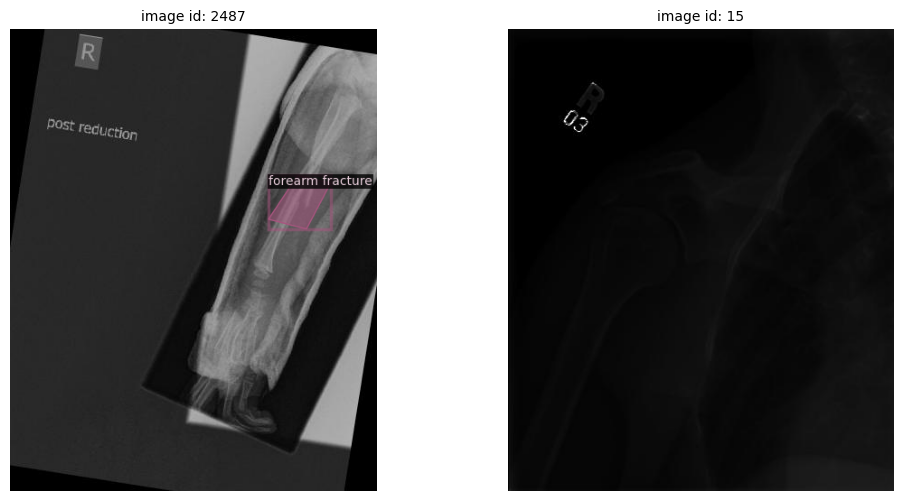

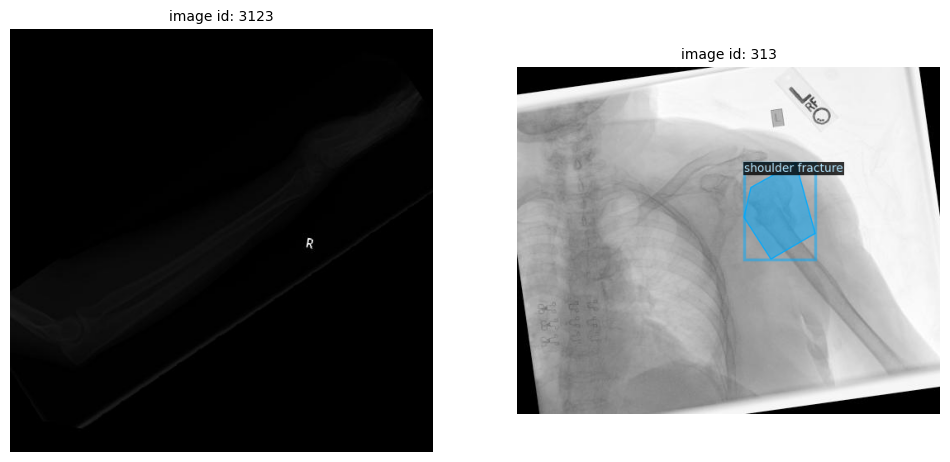

In [8]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 8 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 4 , image_scale = 1)

In [9]:
from detectron2.engine import DefaultTrainer

EPOCHS = 1800
NUM_CLASSES = 8
BASE_LR = 0.0005

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

In [ ]:
cfg.DATASETS.TRAIN = ("bone_fractures_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/24 15:01:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/24 15:01:52 d2.utils.events]:  eta: 0:34:31  iter: 19  total_loss: 2.364  loss_cls: 2.189  loss_box_reg: 0.0204  loss_rpn_cls: 0.1594  loss_rpn_loc: 0.01031    time: 1.1466  last_time: 1.3025  data_time: 0.0118  last_data_time: 0.0054   lr: 9.9905e-06  max_mem: 5910M
[10/24 15:02:19 d2.utils.events]:  eta: 0:34:32  iter: 39  total_loss: 1.95  loss_cls: 1.669  loss_box_reg: 0.009679  loss_rpn_cls: 0.1659  loss_rpn_loc: 0.01187    time: 1.1508  last_time: 1.2839  data_time: 0.0057  last_data_time: 0.0066   lr: 1.998e-05  max_mem: 5910M


In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

In [ ]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric